In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os, sys
from astropy.stats import sigma_clip
from datetime import datetime
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set(style='whitegrid')
from scipy.stats import norm
import pandas as pd
import warnings
import matplotlib.mlab as mlab
from pandas import DataFrame
import sep

In [2]:
pwd

'/home/jovyan/ASTR_136/Cluster'

### MASTER BIAS

In [3]:
filedir = '/home/jovyan/ASTR_136/Cluster/BIAS' 
files_bias = [os.path.join(filedir, f) for f in os.listdir(filedir)]

In [4]:
#biasdata = np.zeros((510, 765, len(files_bias)))
biasdata = []
bias_exp = []
    
for i in range(len(files_bias)):
    hdu = fits.open(files_bias[i])
    if not hdu[0].header['EXPTIME']:
        biasdata.append(hdu[0].data)
        bias_exp.append(hdu[0].header['EXPTIME'])        
        
biasdata = np.stack(biasdata, axis=-1)

In [49]:
bias_data = biasdata[:,:1024,:]

In [50]:
bias_data.shape

(1024, 1024, 10)

In [51]:
bias_mean = np.mean(bias_data,axis=(0,1))
bias_median = np.median(bias_data,axis=(0,1))
bias_std = np.std(bias_data, axis = (0,1))
bias_counts = np.sum(bias_data, axis=(0,1))
bias_count_error = np.sqrt(bias_mean)

biasdata_clipped = sigma_clip(bias_data)
bias_master = np.median(biasdata_clipped, axis=2)

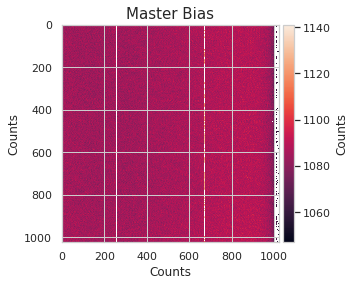

In [52]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(bias_master)
plt.title('Master Bias', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### MASTER DARK

In [53]:
filedir = '/home/jovyan/ASTR_136/Cluster/DARK'
files_dark = [os.path.join(filedir, f) for f in os.listdir(filedir)]

In [56]:
dark_data = []
dark_exp = []

for i in range(len(files_dark)):
    hdu_dark = fits.open(files_dark[i])
    if hdu_dark[0].header['EXPTIME'] > 0:
        correct_dark = (hdu_dark[0].data[:,:1024] - bias_master)/hdu_dark[0].header['EXPTIME']
        dark_data.append(correct_dark)
        dark_exp.append(hdu_dark[0].header['EXPTIME'])

dark_data = np.stack(dark_data, axis=-1)

In [58]:
dark_mean = np.mean(dark_data,axis=(0,1))
dark_median = np.median(dark_data,axis=(0,1))
dark_std = np.std(dark_data, axis = (0,1))
dark_counts = np.sum(dark_data, axis=(0,1))
dark_count_error = np.sqrt(dark_mean)

dark_clipped = sigma_clip(dark_data)
dark_master = np.median(dark_clipped, axis=2)

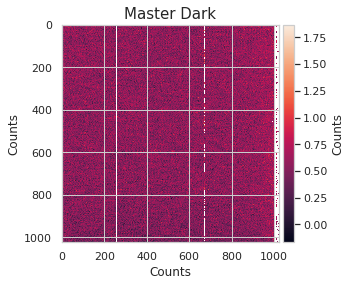

In [59]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(dark_master)
plt.title('Master Dark', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

### MASTER FLAT-B

In [60]:
filedir = '/home/jovyan/ASTR_136/Cluster/FLAT/B_Flat'
files_flat_b = [os.path.join(filedir, f) for f in os.listdir(filedir) if f.endswith('.fits')]

In [61]:
flat_exp_b = []
flat_data_b = []

for i in range(len(files_flat_b)):
    hdu_flat_b = fits.open(files_flat_b[i])
    if hdu_flat_b[0].header['EXPTIME'] > 0:
        corr_flat_b = (((hdu_flat_b[0].data[:,:1024] - bias_master)/hdu_flat_b[0].header['EXPTIME']) - dark_master)
        flat_clipped_b = sigma_clip(corr_flat_b)
        flat_min_b = np.min(flat_clipped_b)
        flat_norm_b = (flat_clipped_b / flat_min_b)
        flat_data_b.append(flat_norm_b)
        flat_exp_b.append(hdu_flat_b[0].header['EXPTIME'])

flat_masks_b = [arr.mask for arr in flat_data_b] # Get masks for each image in flat_data
flat_data_b = np.ma.masked_array(data=np.dstack(flat_data_b),
                                 mask=np.dstack(flat_masks_b)) # Create stacked masked array

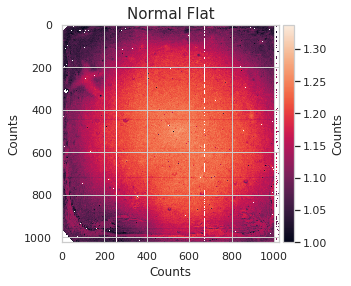

In [63]:
ax = plt.subplot(111)
im = ax.imshow(flat_norm_b)
plt.title('Normal Flat', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

In [64]:
flat_mean_b = np.mean(flat_data_b, axis = (0,1))
flat_median_b = np.median(flat_data_b, axis =(0,1))
flat_std_b = np.std(flat_data_b, axis = (0,1))
flat_counts_b = np.sum(flat_data_b, axis=(0,1))
flat_count_error_b = np.sqrt(flat_mean_b)

flat_master_b = np.median(flat_data_b, axis=2)

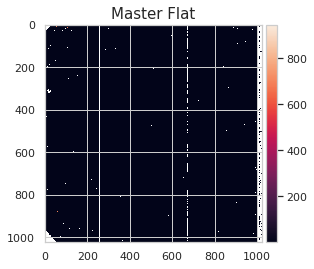

In [65]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(flat_master_b)
plt.title('Master Flat', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER FLAT-V

In [66]:
filedir = '/home/jovyan/ASTR_136/Cluster/FLAT/V_Flat'
files_flat_v = [os.path.join(filedir, f) for f in os.listdir(filedir) if f.endswith('.fits')]

In [67]:
flat_exp_v = []
flat_data_v = []

for i in range(len(files_flat_v)):
    hdu_flat_v = fits.open(files_flat_v[i])
    if hdu_flat_v[0].header['EXPTIME'] > 0:
        corr_flat_v = (((hdu_flat_v[0].data[:,:1024] - bias_master)/hdu_flat_v[0].header['EXPTIME']) - dark_master)
        flat_clipped_v = sigma_clip(corr_flat_v)
        flat_min_v = np.min(flat_clipped_v)
        flat_norm_v = (flat_clipped_v/ flat_min_v)
        flat_data_v.append(flat_norm_v)
        flat_exp_v.append(hdu_flat_v[0].header['EXPTIME'])

flat_masks_v = [arr.mask for arr in flat_data_v] # Get masks for each image in flat_data
flat_data_v = np.ma.masked_array(data=np.dstack(flat_data_v),
                                 mask=np.dstack(flat_masks_v)) # Create stacked masked array

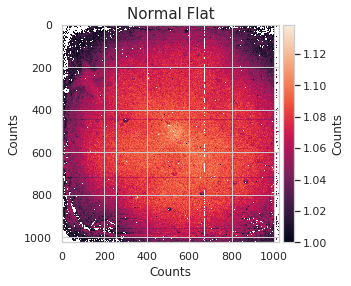

In [68]:
ax = plt.subplot(111)
im = ax.imshow(flat_norm_v)
plt.title('Normal Flat', loc= 'center', fontsize=15)
plt.xlabel('Counts')
plt.ylabel('Counts')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im,  cax=cax)
cbar.ax.set_ylabel('Counts')

plt.show()

In [69]:
flat_mean_v = np.mean(flat_data_v, axis = (0,1))
flat_median_v = np.median(flat_data_v, axis =(0,1))
flat_std_v = np.std(flat_data_v, axis = (0,1))
flat_counts_v = np.sum(flat_data_v, axis=(0,1))
flat_count_error_v = np.sqrt(flat_mean_v)

flat_master_v = np.median(flat_data_v, axis=2)

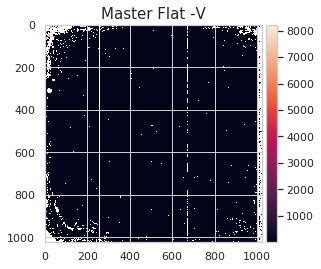

In [70]:
warnings.filterwarnings("ignore")

ax = plt.subplot(111)
im = ax.imshow(flat_master_v)
plt.title('Master Flat -V', loc= 'center', fontsize=15)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)


plt.show()

### MASTER SCIENCE +2 2711 -B

In [240]:
filedir = '/home/jovyan/ASTR_136/Cluster/SCI/+2 2711/B'
files_science_2B = [os.path.join(filedir, f) for f in os.listdir(filedir)if f.endswith('.fits')]

In [243]:
hdu_sci_2B = fits.open(files_science_2B[0])
header_sci_2B = hdu_sci_2B[0].header
science_exp_2B = hdu_sci_2B[0].header['EXPTIME']
time_2B = hdu_sci_2B[0].header['DATE-BEG']

sci_clipped_2B = sigma_clip(hdu_sci_2B[0].data[:,:1024])
correct_sci_2B = (((sci_clipped_2B - bias_master) /
                             header_sci_2B['EXPTIME']) - dark_master
                             ) / flat_master_b
science_data_2B = correct_sci_2B
science_data_2B = np.array(science_data_2B)

In [244]:
sci_mean_2B = np.mean(science_data_2B, axis=(0,1))
sci_median_2B = np.median(science_data_2B, axis = (0,1))
sci_std_2B = np.std(science_data_2B, axis=(0,1))
sci_counts_2B = np.sum(science_data_2B, axis = (0,1))
sci_count_error_2B = np.sqrt(sci_mean_2B)

In [247]:
science_data_2B = science_data_2B.byteswap().newbyteorder()

In [248]:
background_2B = sep.Background(science_data_2B) #finds background of each image
image_2B = science_data_2B- background_2B #subtracts background
catalog_2B = sep.extract(image_2B, 10, err =background_2V.globalrms)

In [251]:
summ_B, sumerror, flags = sep.sum_circle(image_2B,catalog_2B['x'], catalog_2B['y'], 19, 
                              err = sci_count_error_2B, gain = 1 ) #counts/aperature

In [253]:
m_AB = 10.37 +0.02
flux_2B = np.array(summ_B)
mag_instru_B = -2.5 * np.log10(flux_2B)
m_i_B = np.min(mag_instru)
zero_point_B = m_AB - m_i

print('zero point (B)=', zero_point_B)

zero point (B)= 26.35033057630099


### MASTER SCIENCE +2 2711 -V

In [128]:
filedir = '/home/jovyan/ASTR_136/Cluster/SCI/+2 2711/V'
files_science_2V = [os.path.join(filedir, f) for f in os.listdir(filedir)if f.endswith('.fits')]

In [216]:
hdu_sci_2V = fits.open(files_science_2V[0])
header_sci_2V = hdu_sci_2V[0].header
science_exp_2V = hdu_sci_2V[0].header['EXPTIME']

sci_clipped_2V = sigma_clip(hdu_sci_2V[0].data[:,:1024])
correct_sci_2V = (((sci_clipped_2V - bias_master) /
                             header_sci_2V['EXPTIME']) - dark_master
                             ) / flat_master_v

science_data_2V = correct_sci_2V
science_data_2V = np.array(science_data_2V)

In [219]:
sci_mean_2V = np.mean(science_data_2V, axis=(0,1))
sci_median_2V = np.median(science_data_2V, axis = (0,1))
sci_std_2V = np.std(science_data_2V, axis=(0,1))
sci_counts_2V = np.sum(science_data_2V, axis = (0,1))
sci_count_error_2V = np.sqrt(sci_mean_2V)

In [233]:
science_data_2V = science_data_2V.byteswap().newbyteorder()

In [257]:
background_2V = sep.Background(science_data_2V) #finds background of each image
image_2V = science_data_2V- background_2V #subtracts background
catalog_2V = sep.extract(image_2V, 10, err =background_2V.globalrms)

In [258]:
summ_V, sumerror, flags = sep.sum_circle(image_2V,catalog_2V['x'], catalog_2V['y'], 19, 
                              err = sci_count_error_2V, gain = 1 ) #counts/aperature

In [259]:
m_AB = 10.37 +0.02
flux_2V = np.array(summ_V)
mag_instru_V = -2.5 * np.log10(flux_2V)
m_i_V = np.min(mag_instru_V)
zero_point_V = m_AB - m_i_V

print('zero point (V)=', zero_point_V)

zero point (V)= 26.278852143318602


### SCIENCE M67 -B

In [498]:
filedir_1 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/B/1'
d_1 = [os.path.join(filedir_1, f) for f in os.listdir(filedir_1)if f.endswith('.fits')] #directory

filedir_2 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/B/2'
d_2 = [os.path.join(filedir_2, f) for f in os.listdir(filedir_2)if f.endswith('.fits')]

filedir_3 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/B/3'
d_3 = [os.path.join(filedir_3, f) for f in os.listdir(filedir_3)if f.endswith('.fits')] 

filedir_4 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/B/4'
d_4 = [os.path.join(filedir_4, f) for f in os.listdir(filedir_4)if f.endswith('.fits')] 

filedir_5 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/B/5'
d_5 = [os.path.join(filedir_5, f) for f in os.listdir(filedir_5)if f.endswith('.fits')] 

In [499]:
def open_data_b(directory): #opens data per pointing for B band

    pointing = []
    exp = []

    for i in range(len(directory)):
        hdu_sci_MB = fits.open(directory[i])
        header_sci_MB = hdu_sci_MB[0].header
        if header_sci_MB['EXPTIME'] > 0:
            sci_clipped_MB = sigma_clip(hdu_sci_MB[0].data[:,:1024])
            correct_sci_MB= (((sci_clipped_MB - bias_master) /
                             header_sci_MB['EXPTIME']) - dark_master
                             ) / flat_master_b
            pointing.append(correct_sci_MB)
            exp.append(hdu_sci_MB[0].header['EXPTIME'])
            #time_MB = hdu_sci_MB[0].header['DATE-BEG']

    pointing = np.stack(pointing, axis =-1)
    pointing = np.array(pointing)
    
    return pointing

#################################################################################

def open_data_v(directory): #opens data per pointing for V band

    pointing = []
    exp = []

    for i in range(len(directory)):
        hdu_sci_MB = fits.open(directory[i])
        header_sci_MB = hdu_sci_MB[0].header
        if header_sci_MB['EXPTIME'] > 0:
            sci_clipped_MB = sigma_clip(hdu_sci_MB[0].data[:,:1024])
            correct_sci_MB= (((sci_clipped_MB - bias_master) /
                             header_sci_MB['EXPTIME']) - dark_master
                             ) / flat_master_v
            pointing.append(correct_sci_MB)
            exp.append(hdu_sci_MB[0].header['EXPTIME'])
            #time_MB = hdu_sci_MB[0].header['DATE-BEG']

    pointing = np.stack(pointing, axis =-1)
    pointing = np.array(pointing)
    
    return pointing

##################################################################################

def master_science(pointing): #makes master science frame per pointing
    sci_median_MB = np.median(pointing, axis = 2)
    sci_std_MB = np.std(pointing, axis=(0,1))
    sci_counts_MB = np.sum(pointing, axis = (0,1))
    
    return sci_median_MB

###############################################################################

def counts_error(pointing): #calculates count errors per pointing
    sci_mean_MB = np.mean(pointing, axis=2)
    sci_count_error_MB = np.sqrt(sci_mean_MB)
    return sci_count_error_MB

###############################################################################

def find_mag(master_science, counts_err): #calculates the magnitudes of each object per pointing
    flux = []
    background = sep.Background(master_science)
    master_science = master_science.byteswap().newbyteorder()
    image = master_science - background
    catalog= sep.extract(image, 10, err =background.globalrms)
    summ, sumerror, flags = sep.sum_circle(image,catalog['x'], catalog['y'], 19, 
                              err = counts_err, gain = 1 ) #counts/aperature
    flux.append(summ)
    flux = np.array(flux)
    mag = -2.5 * np.log10(flux)
    mag = mag.flatten()

    return mag


In [500]:
directories = d_1, d_2, d_3, d_4, d_5
master_MB = []
count_error_MB = []

for pointings in directories:
    p = open_data_b(pointings) #produces science images of that pointing
    master_p = master_science(p) #produces master science image of that pointing 
    count_error = counts_error(p)
    master_MB.append(master_p)
    count_error_MB.append(count_error)
    
master_MB= np.array(master_MB) #spits out a master science/pointing
count_error_MB = np.array(count_error_MB) #spits out a count error/pointing

In [501]:
mag = []
for i in range(len(master_MB)):
    magnitude = find_mag(master_MB[i], count_error_MB[i])
    mags = magnitude + zero_point_B 
    mag.append(mags)

In [502]:
MB_1 = mag[0] #magnitude in B band/pointing
MB_2 = mag[1]
MB_3 = mag[2]
MB_4 = mag[3]
MB_5 = mag[4]

### MASTER SCIENCE M67 -V

In [510]:
filedir_1 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/V/1'
d_1 = [os.path.join(filedir_1, f) for f in os.listdir(filedir_1)if f.endswith('.fits')] #directory

filedir_2 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/V/2'
d_2 = [os.path.join(filedir_2, f) for f in os.listdir(filedir_2)if f.endswith('.fits')]

filedir_3 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/V/3'
d_3 = [os.path.join(filedir_3, f) for f in os.listdir(filedir_3)if f.endswith('.fits')] 

filedir_4 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/V/4'
d_4 = [os.path.join(filedir_4, f) for f in os.listdir(filedir_4)if f.endswith('.fits')] 

filedir_5 = '/home/jovyan/ASTR_136/Cluster/SCI/M67/V/5'
d_5 = [os.path.join(filedir_5, f) for f in os.listdir(filedir_5)if f.endswith('.fits')] 

In [511]:
directories = d_1, d_2, d_3, d_4, d_5
master_MB = []
count_error_MB = []

for pointings in directories:
    p = open_data_v(pointings) #produces science images of that pointing
    master_p = master_science(p) #produces master science image of that pointing 
    count_error = counts_error(p)
    master_MB.append(master_p)
    count_error_MB.append(count_error)
    
master_MB= np.array(master_MB) #spits out a master science/pointing
count_error_MB = np.array(count_error_MB) #spits out a count error/pointin

In [512]:
mag = []
for i in range(len(master_MB)):
    magnitude = find_mag(master_MB[i], count_error_MB[i])
    mags = magnitude + zero_point_V 
    mag.append(mags)

In [519]:
MV_1 = mag[0] #magnitude in B band/pointing
MV_2 = mag[1]
MV_3 = mag[2]
MV_4 = mag[3]
MV_5 = mag[4]